In [1]:
import math
from urllib.request import urlopen

import matplotlib as mpl
import matplotlib.patheffects as path_effects
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image

from mplsoccer import VerticalPitch, Sbopen, FontManager, inset_image

# data parser, fonts and path effects for giving the font an edge
parser = Sbopen()
roboto_bold = FontManager(
    'https://raw.githubusercontent.com/google/fonts/main/apache/robotoslab/RobotoSlab%5Bwght%5D.ttf')
path_eff = [path_effects.Stroke(linewidth=3, foreground='white'),
            path_effects.Normal()]

# GET STATSBOMB DATA

In [2]:
parser = Sbopen()
event, related, freeze, tactics = parser.event(69249)
# starting players from Barcelona
starting_xi_event = event.loc[((event['type_name'] == 'Starting XI') &
                               (event['team_name'] == 'Barcelona')), ['id', 'tactics_formation']]
# joining on the team name and formation to the lineup
starting_xi = tactics.merge(starting_xi_event, on='id')
# replace player names with the shorter version
player_short_names = {'Víctor Valdés Arribas': 'Víctor Valdés',
                      'Daniel Alves da Silva': 'Dani Alves',
                      'Gerard Piqué Bernabéu': 'Gerard Piqué',
                      'Carles Puyol i Saforcada': 'Carles Puyol',
                      'Eric-Sylvain Bilal Abidal': 'Eric Abidal',
                      'Gnégnéri Yaya Touré': 'Yaya Touré',
                      'Andrés Iniesta Luján': 'Andrés Iniesta',
                      'Xavier Hernández Creus': 'Xavier Hernández',
                      'Lionel Andrés Messi Cuccittini': 'Lionel Messi',
                      'Thierry Henry': 'Thierry Henry',
                      "Samuel Eto''o Fils": "Samuel Eto'o"}
starting_xi['player_name'] = starting_xi['player_name'].replace(player_short_names)
# filter only succesful ball receipts from the starting XI
event = event.loc[((event['type_name'] == 'Ball Receipt') &
                   (event['outcome_name'].isnull()) &
                   (event['player_id'].isin(starting_xi['player_id']))
                   ), ['player_id', 'x', 'y']]
# merge on the starting positions to the events
event = event.merge(starting_xi, on='player_id')
formation = event['tactics_formation'].iloc[0]

In [5]:
event, formation


(     player_id      x     y  jersey_number  match_id  \
 0       5503.0   61.1  39.8             10     69249   
 1       5213.0   32.3  45.3              3     69249   
 2      20131.0   95.7  50.8              6     69249   
 3      20177.0   20.6  22.4             22     69249   
 4       5216.0   35.5  22.8              8     69249   
 ..         ...    ...   ...            ...       ...   
 486     5213.0   46.6  46.5              3     69249   
 487    20125.0   47.6  25.9              5     69249   
 488    20177.0   61.6  28.5             22     69249   
 489    20131.0   73.7  48.9              6     69249   
 490    19298.0  105.0  22.8              9     69249   
 
                                        id       player_name  position_id  \
 0    5a6147af-2d23-48a1-82fc-3e811d9d7c9c      Lionel Messi           17   
 1    5a6147af-2d23-48a1-82fc-3e811d9d7c9c      Gerard Piqué            3   
 2    5a6147af-2d23-48a1-82fc-3e811d9d7c9c  Xavier Hernández           15   
 3    

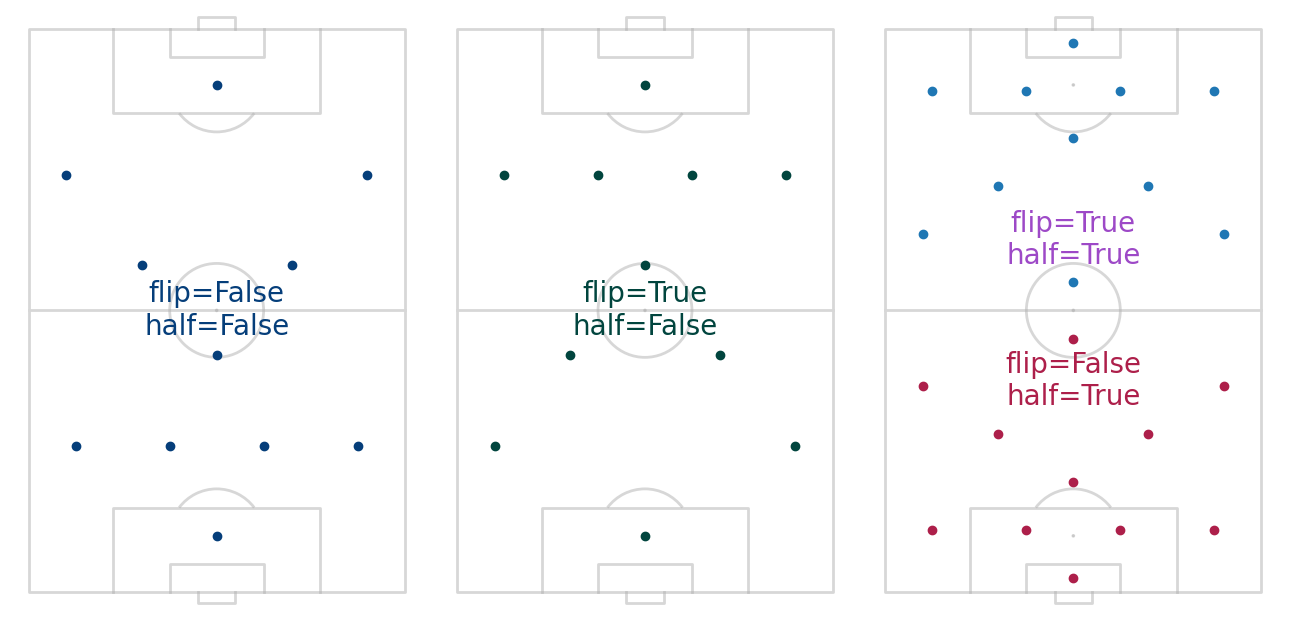

In [7]:
### Diferentes formas de dibujar las formaciones

pitch = VerticalPitch(line_alpha=0.5, goal_type='box', goal_alpha=0.5)
fig, ax = pitch.draw(ncols=3, figsize=(13, 9))
sc_full = pitch.formation(formation, positions=starting_xi.position_id, c='#053e7a', ax=ax[0])
sc_flip = pitch.formation(formation, positions=starting_xi.position_id, c='#01453e', flip=True,
                          ax=ax[1])
sc_half = pitch.formation(formation, positions=starting_xi.position_id, c='#ad1f4a', half=True,
                          ax=ax[2])
sc_half_flip = pitch.formation(formation, positions=starting_xi.position_id, kind='scatter',
                               flip=True, half=True, ax=ax[2])

txt_full = pitch.text(60, 40, 'flip=False\nhalf=False', ax=ax[0], va='center', ha='center',
                      color='#053e7a', fontsize=20)
txt_flip = pitch.text(60, 40, 'flip=True\nhalf=False', ax=ax[1], va='center', ha='center',
                      color='#01453e', fontsize=20)
txt_half = pitch.text(45, 40, 'flip=False\nhalf=True', ax=ax[2], va='center', ha='center',
                      color='#ad1f4a', fontsize=20)
txt_half_flip = pitch.text(75, 40, 'flip=True\nhalf=True', ax=ax[2], va='center', ha='center',
                           color='#9d49c7', fontsize=20)

## PLOT IMAGES

In [8]:
image_urls = {
    # Credit: Darz Mol. Creative Commons Attribution-Share Alike 2.5 Spain license.
    # https://en.wikipedia.org/wiki/V%C3%ADctor_Vald%C3%A9s#/media/File:Victor_Valdes_15abr2007.jpg
    'Víctor Valdés': 'https://upload.wikimedia.org/wikipedia/commons/4/46/Victor_Valdes_15abr2007.jpg',
    # Credit: Football.ua. CC BY-SA 3.0
    # https://en.wikipedia.org/wiki/Dani_Alves#/media/File:2015_UEFA_Super_Cup_107.jpg
    'Dani Alves': 'https://upload.wikimedia.org/wikipedia/commons/1/1f/2015_UEFA_Super_Cup_107.jpg',
    # Credit: Shay. CC BY-SA 3.0
    # https://en.wikipedia.org/wiki/Gerard_Piqu%C3%A9#/media/File:Gerard_Pique.jpg
    'Gerard Piqué': 'https://upload.wikimedia.org/wikipedia/commons/e/e1/Gerard_Pique.jpg',
    # Credit: Shay. CC BY-SA 3.0
    # https://en.wikipedia.org/wiki/Carles_Puyol#/media/File:Carles_Puyol_Joan_Gamper-Tr.jpg
    'Carles Puyol': 'https://upload.wikimedia.org/wikipedia/commons/6/60/Carles_Puyol_Joan_Gamper-Tr.jpg',
    # Credit: Mutari. Public Domain
    # https://en.wikipedia.org/wiki/Eric_Abidal#/media/File:%C3%89ric_Abidal_-_001.jpg
    'Eric Abidal': 'https://upload.wikimedia.org/wikipedia/commons/c/c8/%C3%89ric_Abidal_-_001.jpg',
    # Credit: Football.ua. CC BY-SA 3.0
    # https://en.wikipedia.org/wiki/Yaya_Tour%C3%A9#/media/File:Yaya_Tour%C3%A9.JPG
    'Yaya Touré': 'https://upload.wikimedia.org/wikipedia/commons/e/ee/Yaya_Tour%C3%A9.JPG',
    # Credit: Darz Mol CC BY-SA 2.5 es
    # https://en.wikipedia.org/wiki/Andr%C3%A9s_Iniesta#/media/File:Andr%C3%A9s_Iniesta_21dec2006.jpg
    'Andrés Iniesta': 'https://upload.wikimedia.org/wikipedia/commons/e/ed/Andr%C3%A9s_Iniesta_21dec2006.jpg',
    # Credit: Castroquini. CC BY-SA 3.0
    # https://en.wikipedia.org/wiki/Xavi#/media/File:2012_2013_-_06_Xavi_Hern%C3%A1ndez.jpg
    'Xavier Hernández': 'https://upload.wikimedia.org/wikipedia/commons/9/93/2012_2013_-_06_Xavi_Hern%C3%A1ndez.jpg',
    # Credit: Tasnim News Agency. CC BY 4.0
    # https://fi.wikipedia.org/wiki/Lionel_Messi#/media/Tiedosto:Lionel-Messi-Argentina-2022-FIFA-World-Cup_(cropped).jpg
    'Lionel Messi': 'https://upload.wikimedia.org/wikipedia/commons/b/b4/Lionel-Messi-Argentina-2022-FIFA-World-Cup_%28cropped%29.jpg',
    # Credit: Shay. CC BY-SA 3.0
    # https://en.wikipedia.org/wiki/Thierry_Henry#/media/File:Thierry_Henry_2008.jpg
    'Thierry Henry': 'https://upload.wikimedia.org/wikipedia/commons/6/6e/Thierry_Henry_2008.jpg',
    # Credit: Shay. CC BY-SA 3.0
    # https://en.wikipedia.org/wiki/Samuel_Eto%27o#/media/File:Etoo_Joan_Gamper_Trophy_2008.jpg
    "Samuel Eto'o": 'https://upload.wikimedia.org/wikipedia/commons/7/77/Etoo_Joan_Gamper_Trophy_2008.jpg',
}
images = [Image.open(urlopen(url)) for url in starting_xi.player_name.map(image_urls)]

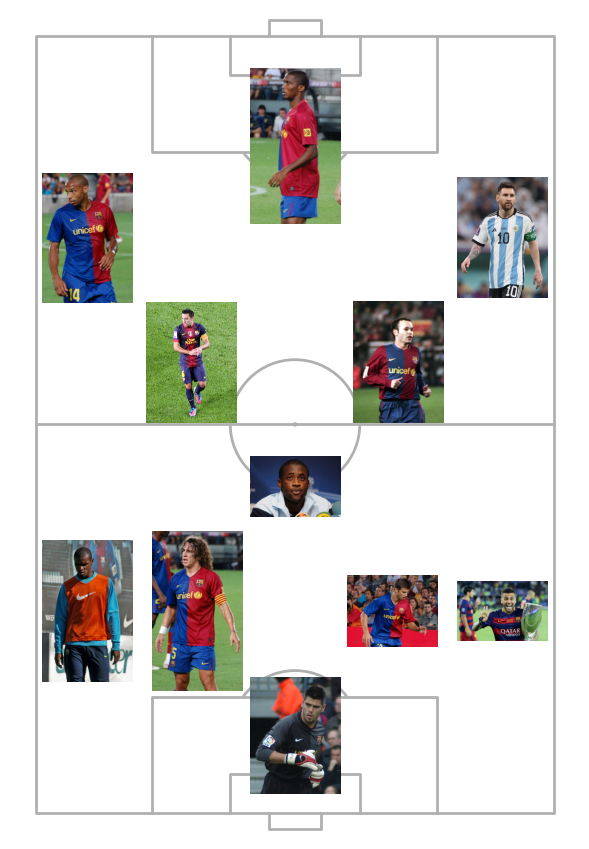

In [9]:
pitch = VerticalPitch(goal_type='box')
fig, ax = pitch.draw(figsize=(6, 8.72))
ax_image = pitch.formation(formation, positions=starting_xi.position_id, kind='image', image=images,
                           width=14,
                           xoffset=[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -5],
                           # xoffset in same order as the positions
                           yoffset=[0, 2, 5, -5, -2, 0, 0, 0, 0, 0, 0],
                           # yoffset in the same order as the positions
                           ax=ax)
# comment below sets this as the thumbnail in the docs
# sphinx_gallery_thumbnail_path = 'gallery/pitch_plots/images/sphx_glr_plot_formations_002'

## TEXT AND SCATTER

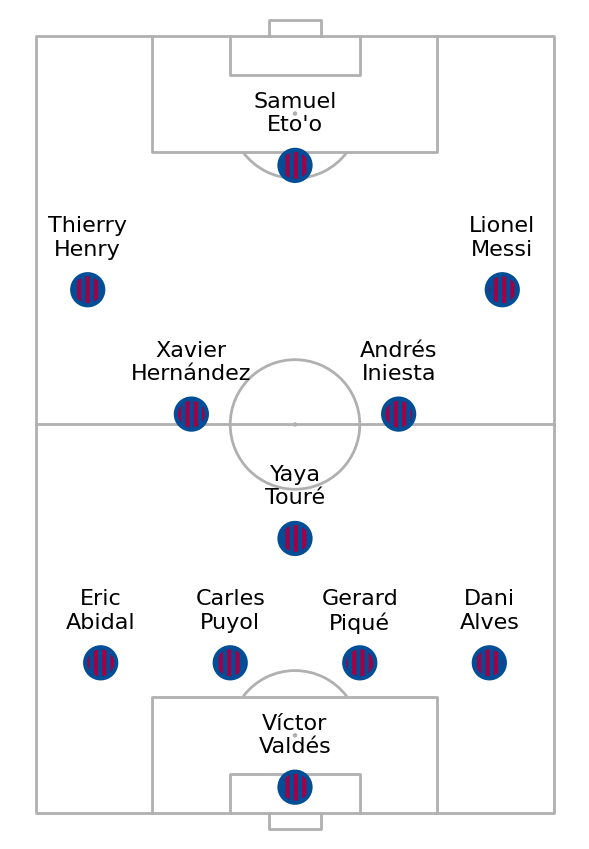

In [10]:
pitch = VerticalPitch(goal_type='box')
fig, ax = pitch.draw(figsize=(6, 8.72))
ax_text = pitch.formation(formation, positions=starting_xi.position_id, kind='text',
                          text=starting_xi.player_name.str.replace(' ', '\n'),
                          va='center', ha='center', fontsize=16, ax=ax)
# scatter markers
mpl.rcParams['hatch.linewidth'] = 3
mpl.rcParams['hatch.color'] = '#a50044'
ax_scatter = pitch.formation(formation, positions=starting_xi.position_id, kind='scatter',
                             c='#004d98', hatch='||', linewidth=3, s=500,
                             # you can also provide a single offset instead of a list
                             # for xoffset and yoffset
                             xoffset=-8,
                             ax=ax)

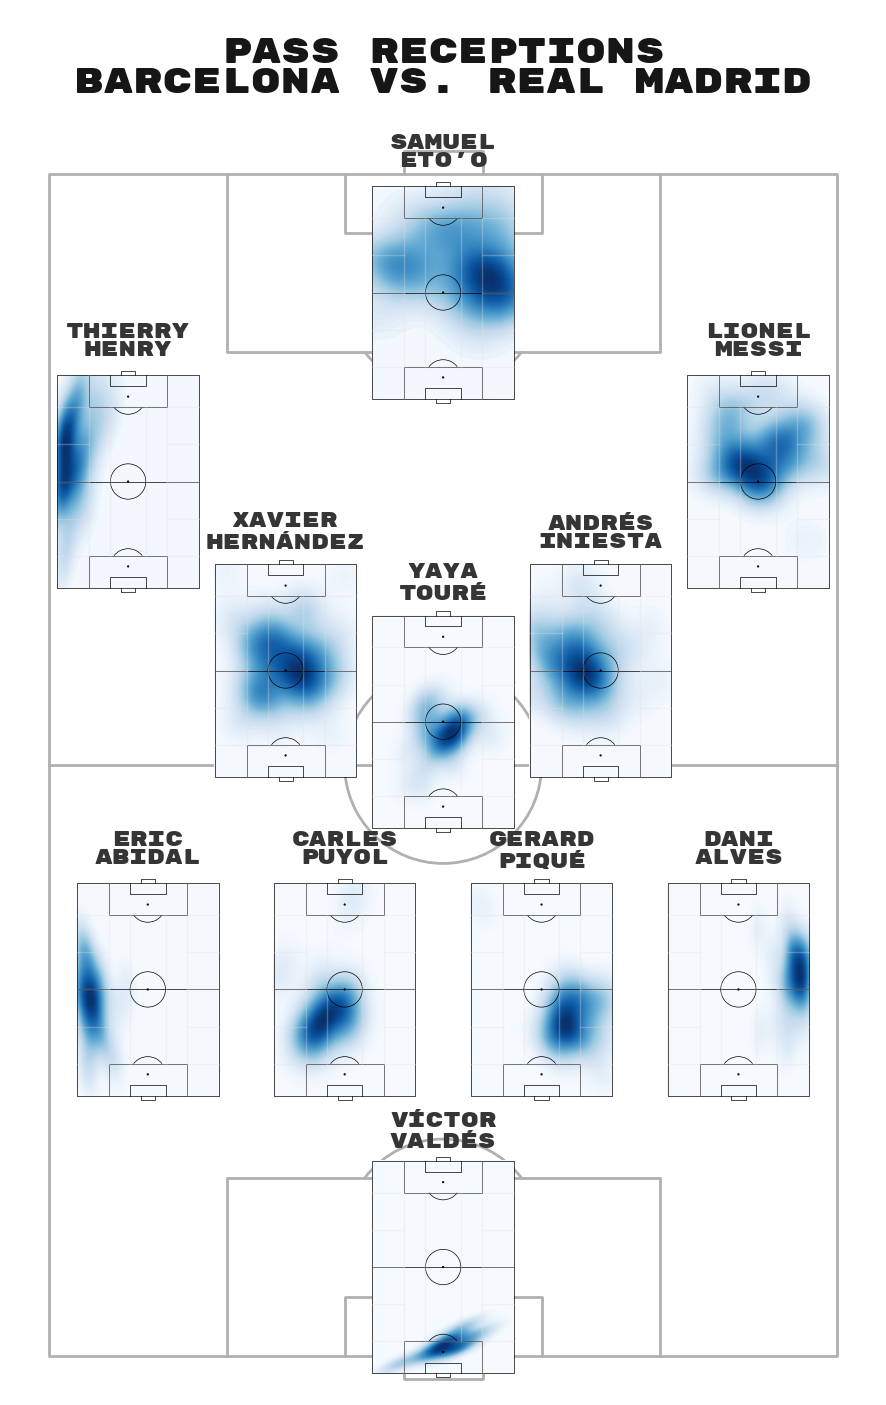

In [11]:
pitch = VerticalPitch(goal_type='box')
fig, axs = pitch.grid(endnote_height=0, title_height=0.08, figheight=14, grid_width=0.9,
                      grid_height=0.9, axis=False)
fm_rubik = FontManager('https://raw.githubusercontent.com/google/fonts/main/ofl/'
                       'rubikmonoone/RubikMonoOne-Regular.ttf')
title = axs['title'].text(0.5, 0.5, 'Pass receptions\nBarcelona vs. Real Madrid', fontsize=25,
                          va='center',
                          ha='center', color='#161616', fontproperties=fm_rubik.prop)

pitch_ax = pitch.formation(formation,
                           kind='pitch',
                           # avoid overlapping pitches with offsets
                           xoffset=[-3, 6, 6, 6, 6, 14, 0, 0, 0, 0, 0],
                           # pitch is 23 units long (could also set the height).
                           # note this is set assuming the pitch is horizontal, but in this example
                           # it is vertical so that you get the same results
                           # from both VerticalPitch and Pitch
                           width=23,
                           positions=starting_xi['position_id'],
                           ax=axs['pitch'],
                           # additional arguments temporarily amend the pitch appearance
                           # note we are plotting a really faint positional grid
                           # that overlays the kdeplot
                           linewidth=0.5,
                           pitch_color='None',
                           line_zorder=3,
                           line_color='black',
                           positional=True,
                           positional_zorder=3,
                           positional_linewidth=1,
                           positional_alpha=0.3,
                           )

# adding kdeplot and player titles
for position in pitch_ax:
    player_name = starting_xi[starting_xi['position_id'] == position].player_name.iloc[0]
    player_name = player_name.replace(' ', '\n').replace('-', '-\n')
    pitch.text(150, 40, player_name, va='top', ha='center', fontsize=15, ax=pitch_ax[position],
               fontproperties=fm_rubik.prop, color='#353535')
    pitch.kdeplot(x=event.loc[event['position_id'] == position, 'x'],
                  y=event.loc[event['position_id'] == position, 'y'],
                  fill=True, levels=100, cut=100, cmap='Blues', thresh=0, ax=pitch_ax[position])

# GET OPTA DATA

In [12]:
totw_player_data = pd.DataFrame(
    {
        'position': ['LW', 'ST', 'RW', 'LCM', 'CDM', 'RCM', 'LB', 'LCB', 'RCB', 'RB', 'GK'],
        'position_id': [11, 9, 10, 8, 4, 7, 3, 6, 5, 2, 1],
        'player': ['Reiten', 'Kerr', 'Fleming', 'Charles', 'Miedema', 'Kirby', 'Blundell',
                   'Greenwood', 'Bryson', 'Battle', 'Earps'],
        'score': [9.7, 8.6, 8.7, 9.1, 8.7, 9.5, 7.6, 8.0, 8.0, 9.1, 8.3],
        'team': ['Chelsea', 'Chelsea', 'Chelsea', 'Chelsea', 'Arsenal', 'Chelsea',
                 'Manchester United', 'Manchester City', 'Reading', 'Manchester United',
                 'Manchester United']
    }
)
totw_player_data

,position,position_id,player,score,team
0,LW,11,Reiten,9.7,Chelsea
1,ST,9,Kerr,8.6,Chelsea
2,RW,10,Fleming,8.7,Chelsea
3,LCM,8,Charles,9.1,Chelsea
4,CDM,4,Miedema,8.7,Arsenal
5,RCM,7,Kirby,9.5,Chelsea
6,LB,3,Blundell,7.6,Manchester United
7,LCB,6,Greenwood,8.0,Manchester City
8,RCB,5,Bryson,8.0,Reading
9,RB,2,Battle,9.1,Manchester United


In [13]:
badge_urls = {
    'Manchester United': 'https://upload.wikimedia.org/wikipedia/en/thumb/7/7a/Manchester_United_FC_crest.svg/250px-Manchester_United_FC_crest.svg.png',
    'Chelsea': 'https://upload.wikimedia.org/wikipedia/en/thumb/c/cc/Chelsea_FC.svg/240px-Chelsea_FC.svg.png',
    'Manchester City': 'https://upload.wikimedia.org/wikipedia/en/thumb/e/eb/Manchester_City_FC_badge.svg/250px-Manchester_City_FC_badge.svg.png',
    'Reading': 'https://upload.wikimedia.org/wikipedia/en/thumb/1/11/Reading_FC.svg/240px-Reading_FC.svg.png',
    'Arsenal': "https://upload.wikimedia.org/wikipedia/en/thumb/5/53/Arsenal_FC.svg/250px-Arsenal_FC.svg.png",
}
image_dict = {team: Image.open(urlopen(url)) for team, url in badge_urls.items()}
images = [image_dict[team] for team in totw_player_data.team]

### PLOT

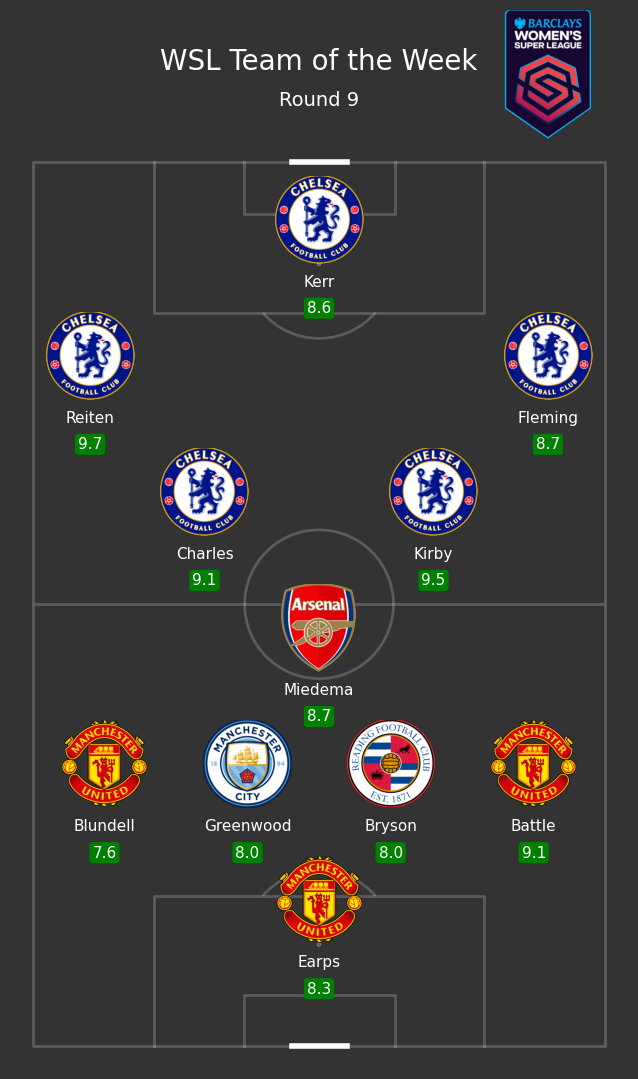

In [14]:
# setup figure
pitch = VerticalPitch(pitch_type='opta', pitch_color='#333333', line_color='white', line_alpha=0.2,
                      line_zorder=3)
fig, axes = pitch.grid(endnote_height=0, figheight=13, title_height=0.1, title_space=0, space=0)
fig.set_facecolor('#333333')

# title
axes['title'].axis('off')
axes['title'].text(0.5, 0.6, 'WSL Team of the Week', ha='center', va='center', color='white',
                   fontsize=20)
axes['title'].text(0.5, 0.3, 'Round 9', ha='center', va='center', color='white', fontsize=14)

# plot the league logo using the inset_image method for utils
LEAGUE_URL = 'https://www.thesportsdb.com/images/media/league/badge/kxo7zf1656519439.png'
image = Image.open(urlopen(LEAGUE_URL))
title_image = inset_image(0.9, 0.5, image, height=1, ax=axes['title'])

text_names = pitch.formation('433', kind='text', positions=totw_player_data.position_id,
                             text=totw_player_data.player, ax=axes['pitch'],
                             xoffset=-2,  # offset the player names from the centers
                             ha='center', va='center', color='white', fontsize=11)
text_scores = pitch.formation('433', kind='text', positions=totw_player_data.position_id,
                              text=totw_player_data.score, ax=axes['pitch'],
                              xoffset=-5,  # offset the scores from the centers
                              ha='center', va='center', color='white', fontsize=11,
                              bbox=dict(facecolor='green', boxstyle='round,pad=0.2', linewidth=0))
badge_axes = pitch.formation('433', kind='image', positions=totw_player_data.position_id,
                             image=images, height=10, ax=axes['pitch'],
                             xoffset=5,  # offset the images from the centers
                             )

# GET WYSCOUT DATA

In [18]:
wyscout_data = {'player_name': ['David de Gea', 'Bailly', 'Maguire', 'Shaw',
                                'Wan-Bissaka', 'Matić', 'Fred', 'Williams',
                                'Bruno Fernandes', 'James', 'Martial'],
                'position_id': ['gk', 'rcb3', 'cb', 'lcb3', 'rwb', 'rcmf', 'lcmf', 'lwb', 'amf',
                                'ss', 'cf'],
                }
WYSCOUT_FORMATION = '3-4-1-2'
df_wyscout = pd.DataFrame(wyscout_data)
df_wyscout

,player_name,position_id
0,David de Gea,gk
1,Bailly,rcb3
2,Maguire,cb
3,Shaw,lcb3
4,Wan-Bissaka,rwb
5,Matić,rcmf
6,Fred,lcmf
7,Williams,lwb
8,Bruno Fernandes,amf
9,James,ss


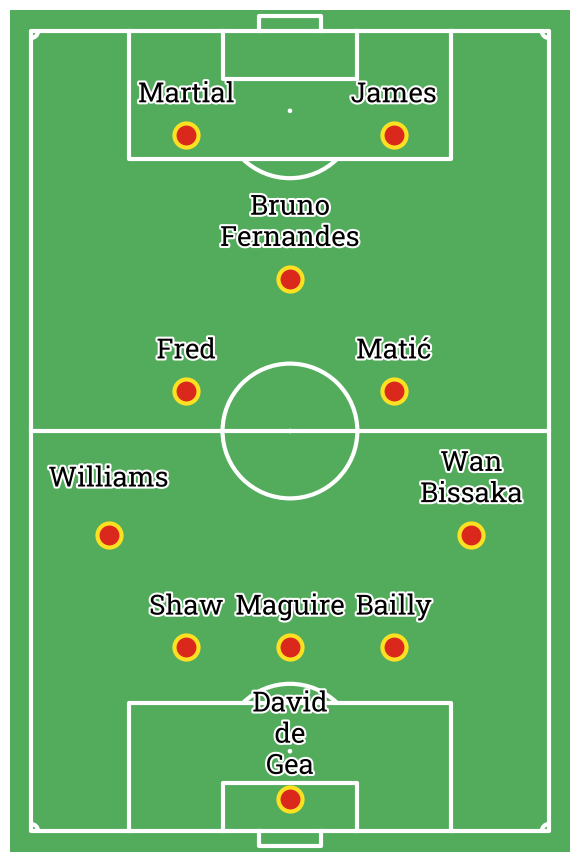

In [19]:
pitch = VerticalPitch(pitch_type='wyscout', goal_type='box', pitch_color='#53ac5c',
                      line_color='white', linewidth=3, corner_arcs=True)
fig, ax = pitch.draw(figsize=(6, 8.72))
sc_formation = pitch.formation(WYSCOUT_FORMATION, positions=wyscout_data['position_id'],
                               ax=ax, c='#DA291C', ec='#FBE122',
                               xoffset=[-6, -3, -3, -3, -5, -3, -3, -5, -5, -3, -3],
                               yoffset=[0, 0, 0, 0, -5, 0, 0, 5, 0, 0, 0],
                               lw=3, s=300)
sc_text = pitch.formation(WYSCOUT_FORMATION, positions=wyscout_data['position_id'],
                          text=df_wyscout['player_name'].str.replace(' ', '\n').str.replace('-',
                                                                                            '\n'),
                          yoffset=[0, 0, 0, 0, -5, 0, 0, 5, 0, 0, 0],
                          kind='text', va='center', ha='center', xoffset=2,
                          fontsize=20, fontproperties=roboto_bold.prop, path_effects=path_eff,
                          ax=ax)

# AVAILABLE FORMATIONS

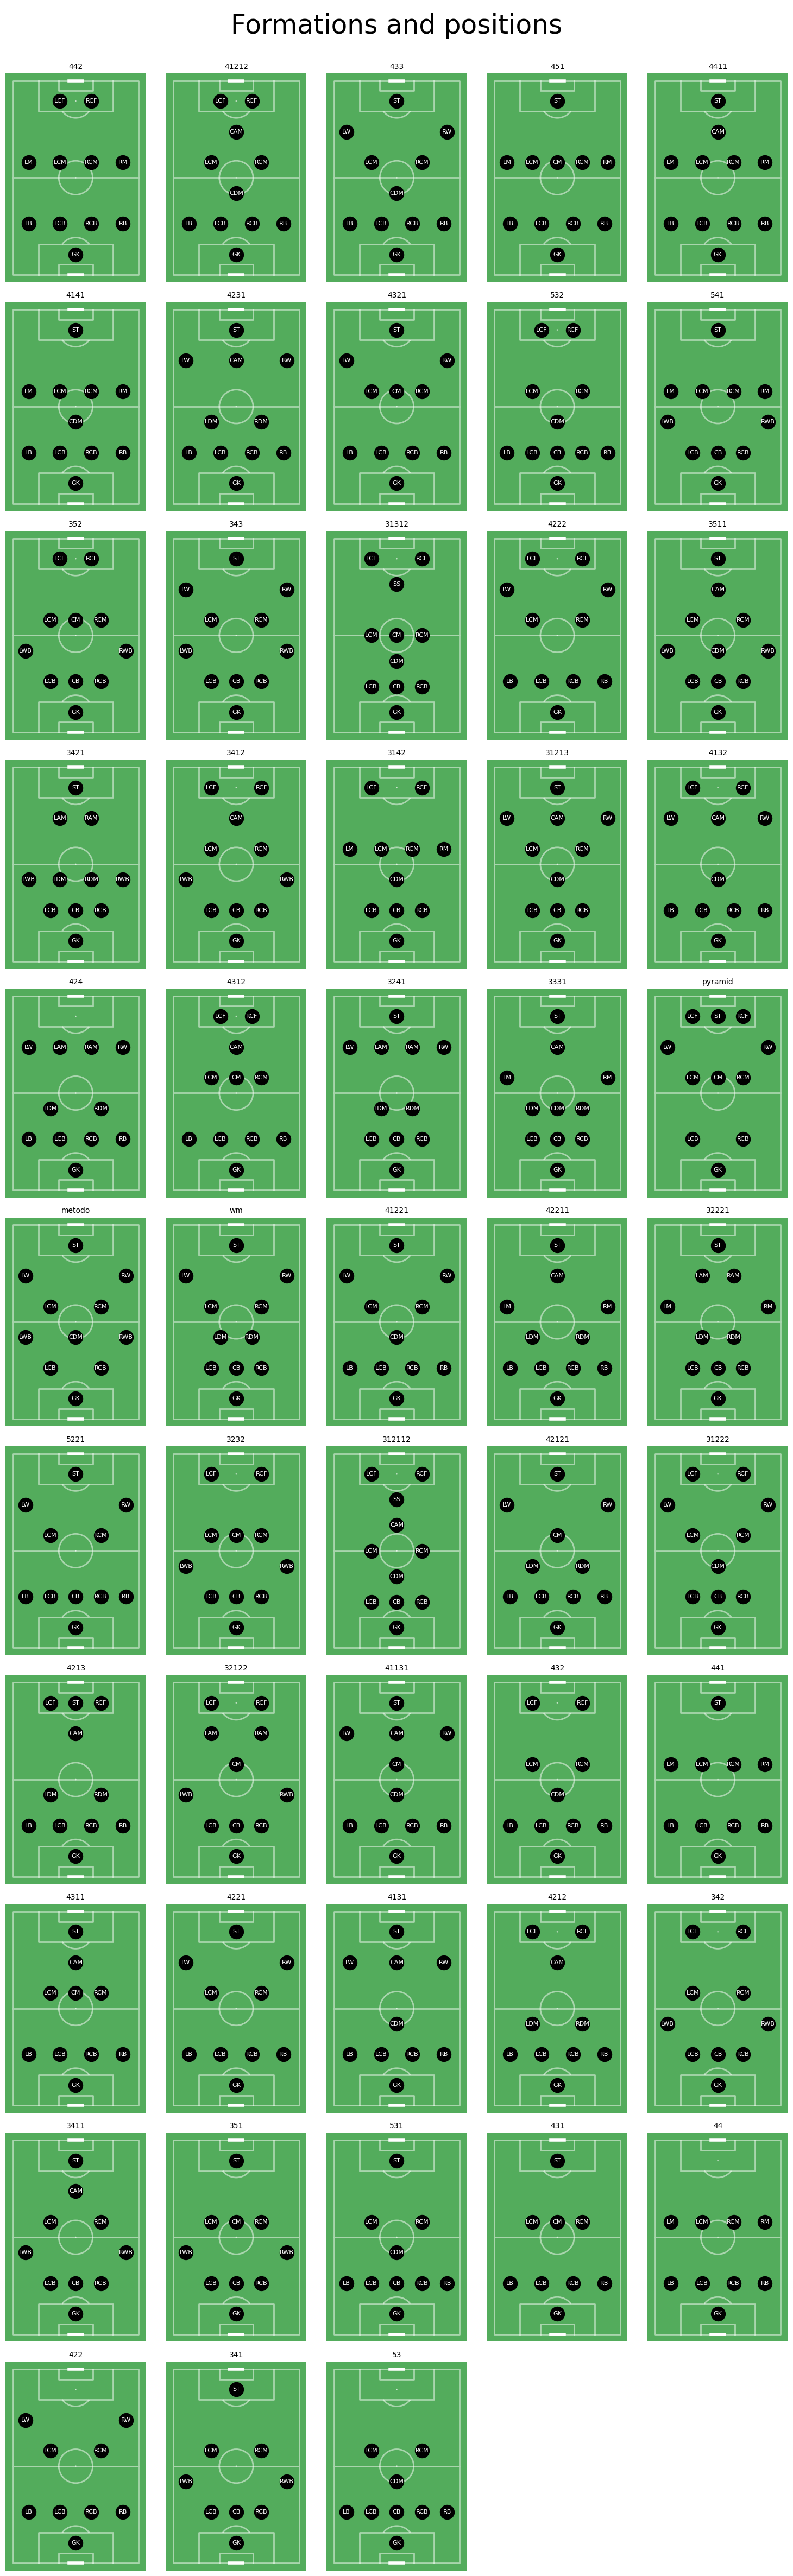

In [15]:
pitch = VerticalPitch('uefa', line_alpha=0.5, pitch_color='#53ac5c', line_color='white')

df_formations = pitch.formations_dataframe
COLS = 5
rows = math.ceil(len(pitch.formations) / COLS)

fig, axes = pitch.grid(nrows=rows, ncols=COLS, title_height=0.015, endnote_height=0, figheight=50,
                       space=0.08, grid_height=0.92)
axes_p = axes['pitch'].flatten()
for i, formation in enumerate(pitch.formations):
    pitch.formation(formation, kind='scatter', color='black', s=350, ax=axes_p[i])
    pitch.formation(formation, kind='text',
                    positions=df_formations.loc[df_formations.formation == formation, 'name'],
                    text=df_formations.loc[df_formations.formation == formation, 'name'],
                    color='white', fontsize=8, ha='center', va='center', ax=axes_p[i])
    axes_p[i].set_title(formation, fontsize=10)
axes['title'].axis('off')
title = axes['title'].text(0.5, 0.5, 'Formations and positions', fontsize=35,
                           ha='center', va='center')

# remove spare axes
number_spare_axes = (COLS * rows) - len(pitch.formations)
for j in range(1, number_spare_axes + 1):
    axes_p[-j].remove()

In [16]:
pitch.get_positions(line=5, second_striker=True)

,x,y,x_flip,y_flip,x_half,y_half,x_half_flip,y_half_flip
GK,11.000000,34.0,94.000000,34.0,2.750,34.0,102.250,34.0
RB,24.833333,6.8,80.166667,61.2,10.125,6.8,94.875,61.2
RCB,24.833333,20.4,80.166667,47.6,10.125,20.4,94.875,47.6
CB,24.833333,34.0,80.166667,34.0,10.125,34.0,94.875,34.0
LCB,24.833333,47.6,80.166667,20.4,10.125,47.6,94.875,20.4
LB,24.833333,61.2,80.166667,6.8,10.125,61.2,94.875,6.8
RWB,38.666667,6.8,66.333333,61.2,17.500,6.8,87.500,61.2
RDM,38.666667,20.4,66.333333,47.6,17.500,20.4,87.500,47.6
CDM,38.666667,34.0,66.333333,34.0,17.500,34.0,87.500,34.0
LDM,38.666667,47.6,66.333333,20.4,17.500,47.6,87.500,20.4
